# Pillow Python Package

Here we are installing Pillow python package from .whl which is required to convert .bmp file to numpy array.

In [ ]:
!pip install Pillow-8.1.0-cp36-cp36m-manylinux1_x86_64.whl --user

# Importing required python packages

In [13]:
import json, yaml
from string import Template

import kfp
from kfp import components
from kfp.components import func_to_container_op
import kfp.dsl as dsl

# Create Persistent Volume Claim and upload required file for model training.

#### Note: We are deploying current usecase in kubeflow namespace as while running TFJob from Kubeflow in other namespace, istio sidecar is automatically attaching to TFJob pod and that is not allowing the model to be trained using optimal parameter. 

### 1- Creating PVC in kubeflow namespace.

```
cat <<EOF | kubectl apply -f -
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: mxnet-mnist-pvc
  namespace: kubeflow
spec:
  accessModes:
  - ReadWriteMany
  resources:
    requests:
      storage: 5Gi
EOF
```

### 2- Starting Utility Pod.

```
apiVersion: v1
kind: Pod
metadata:
    name: dataaccess
    namespace: kubeflow
spec:
    containers:
    - name: alpine
      image: alpine:latest
      command: ['sleep', 'infinity']
      volumeMounts:
      - name: mypvc
        mountPath: /data
    volumes:
    - name: mypvc
      persistentVolumeClaim:
        claimName: mxnet-mnist-pvc
```

### 3- Download below files.

```
wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P /tmp/MXNET-MNIST
wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P /tmp/MXNET-MNIST
wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P /tmp/MXNET-MNIST
wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P /tmp/MXNET-MNIST

```

### 4- Step to copy downloaded files in PV.

```
kubectl -n kubeflow exec -t dataaccess -c alpine  -- mkdir -p /data/MXNET-MNIST
kubectl -n kubeflow cp MXNET-MNIST/t10k-images-idx3-ubyte.gz dataaccess:/data/MXNET-MNIST/t10k-images-idx3-ubyte.gz
kubectl -n kubeflow cp MXNET-MNIST/train-images-idx3-ubyte.gz dataaccess:/data/MXNET-MNIST/train-images-idx3-ubyte.gz
kubectl -n kubeflow cp MXNET-MNIST/t10k-labels-idx1-ubyte.gz dataaccess:/data/MXNET-MNIST/t10k-labels-idx1-ubyte.gz
kubectl -n kubeflow cp MXNET-MNIST/train-labels-idx1-ubyte.gz dataaccess:/data/MXNET-MNIST/train-labels-idx1-ubyte.gz
```

In [14]:
# Name of PVC which we created on above steps.
PVC="mxnet-mnist-pvc"

# Function To Get Optimal Parameter From Experiment

In [15]:
def convert_mnist_experiment_result(experiment_result) -> str:
    import json
    r = json.loads(experiment_result)
    r = r["currentOptimalTrial"]["parameterAssignments"]
    args = []
    for hp in r:
        print(hp)
        args.append("%s=%s" % (hp["name"], hp["value"]))

    return " ".join(args)

# In below cells we all building a spec json for experiment.

In [16]:
# step 1: create a Katib experiment to tune hyperparameters
OBJECTIVE = {
      "type": "minimize",
      "goal": 0.001,
      "objectiveMetricName": "loss",
    }

ALGORITHM = {"algorithmName" : "random"}

PARALLEL_TRIAL_COUNT = 3
MAX_TRIAL_COUNT = 13
MAX_FAILED_TRIAL_COUNT = 2 

PARAMETERS = [
      {"name": "tf-learning-rate", "parameterType": "double", "feasibleSpace": {"min": "0.01","max": "0.03"}},
      {"name": "tf-batch-size", "parameterType": "discrete", "feasibleSpace": {"list": ["16", "32", "64"]}},
]

In [17]:
rawTemplate = {
      "apiVersion": "kubeflow.org/v1",
      "kind": "TFJob",
      "metadata": {
         "name": "{{.Trial}}",
         "namespace": "{{.NameSpace}}"
      },
      "spec": {
        "tfReplicaSpecs": {
          "Chief": {
            "replicas": 1,
            "restartPolicy": "OnFailure",
            "template": {
              "spec": {
                  "volumes": [
              {
                "name": "dataset",
                "persistentVolumeClaim": {
                  "claimName": PVC
                }
              }
            ],
                "containers": [
                {
                  "command": [
                    "sh",
                    "-c"
                  ],
                  "args": [
                    "python /opt/model.py --tf-train-steps=2000 --tf-data-dir=/dataset/MXNET-MNIST {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                  ],
                  "image": "liuhougangxa/tf-estimator-mnist",
                  "name": "tensorflow",
                    "volumeMounts": [
                  {
                    "mountPath": "/dataset",
                    "name": "dataset"
                  }
                ]
                }
                ]
              }
            }
          },
          "Worker": {
            "replicas": 3,
            "restartPolicy": "OnFailure",
            "template": {
              "spec": {
                  "volumes": [
              {
                "name": "dataset",
                "persistentVolumeClaim": {
                  "claimName": PVC
                }
              }
            ],
                "containers": [
                {
                  "command": [
                    "sh",
                    "-c"
                  ],
                  "args": [ 
                    "python /opt/model.py --tf-train-steps=2000 --tf-data-dir=/dataset/MXNET-MNIST {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                  ],
                  "image": "liuhougangxa/tf-estimator-mnist",
                  "name": "tensorflow",
                    "volumeMounts": [
                  {
                    "mountPath": "/dataset",
                    "name": "dataset"
                  }
                ]
                }
                ]
              }
            }
          }
        }
      }
    }


TRIAL_TEMPLATE = {
      "goTemplate": {
        "rawTemplate": json.dumps(rawTemplate)
      }
    }

In [18]:
METRIC_COLLECTOR_SPEC = {
      "source": {
        "fileSystemPath": {
          "path": "/tmp/tf",
          "kind": "Directory"
        }
      },
      "collector": {
        "kind": "TensorFlowEvent"
      }
}

In [19]:
KATIB_EXPERIMENT_SPEC = {
    "metricsCollectorSpec": METRIC_COLLECTOR_SPEC,
    "objective": OBJECTIVE,
    "algorithm": ALGORITHM,
    "parallelTrialCount": PARALLEL_TRIAL_COUNT,
    "maxTrialCount": MAX_TRIAL_COUNT,
    "maxFailedTrialCount": MAX_FAILED_TRIAL_COUNT,
    "parameters": PARAMETERS,
    "trialTemplate": TRIAL_TEMPLATE
}

In [20]:
print(KATIB_EXPERIMENT_SPEC)

{'metricsCollectorSpec': {'source': {'fileSystemPath': {'path': '/tmp/tf', 'kind': 'Directory'}}, 'collector': {'kind': 'TensorFlowEvent'}}, 'objective': {'type': 'minimize', 'goal': 0.001, 'objectiveMetricName': 'loss'}, 'algorithm': {'algorithmName': 'random'}, 'parallelTrialCount': 3, 'maxTrialCount': 13, 'maxFailedTrialCount': 2, 'parameters': [{'name': 'tf-learning-rate', 'parameterType': 'double', 'feasibleSpace': {'min': '0.01', 'max': '0.03'}}, {'name': 'tf-batch-size', 'parameterType': 'discrete', 'feasibleSpace': {'list': ['16', '32', '64']}}], 'trialTemplate': {'goTemplate': {'rawTemplate': '{"apiVersion": "kubeflow.org/v1", "kind": "TFJob", "metadata": {"name": "{{.Trial}}", "namespace": "{{.NameSpace}}"}, "spec": {"tfReplicaSpecs": {"Chief": {"replicas": 1, "restartPolicy": "OnFailure", "template": {"spec": {"volumes": [{"name": "dataset", "persistentVolumeClaim": {"claimName": "mxnet-mnist-pvc"}}], "containers": [{"command": ["sh", "-c"], "args": ["python /opt/model.py --

# Pipeline step to lauch a experiment using katib python sdk (0.0.2)
The below image only support katib v1alpha3 crds.

In [21]:
KATIB_COMPONENT = """
name: Katib - Launch Experiment
description: Katib Experiment launcher
inputs:
- {name: Experiment Name,            type: String,       default: '',        description: 'Experiment name'}
- {name: Experiment Namespace,       type: String,       default: anonymous, description: 'Experiment namespace'}
- {name: Experiment Spec,            type: JsonObject,   default: '{}',      description: 'Experiment specification in dict format'}
- {name: Experiment Timeout Minutes, type: Integer,      default: 1440,      description: 'Time in minutes to wait for the Experiment to complete'}
- {name: Delete Finished Experiment, type: Bool,         default: 'True',    description: 'Whether to delete the Experiment after it is finished'}
outputs:
- {name: Best Parameter Set,         type: JsonObject,                       description: 'The hyperparameter set of the best Experiment Trial'}
implementation:
  container:
    image:  ilovepython/kpl-katib0.0.2:v0.8
    command: [python, src/launch_experiment_alphav3.py]
    args: [
      --experiment-name,            {inputValue: Experiment Name},
      --experiment-namespace,       {inputValue: Experiment Namespace},
      --experiment-spec,            {inputValue: Experiment Spec},
      --experiment-timeout-minutes, {inputValue: Experiment Timeout Minutes},
      --delete-after-done,          {inputValue: Delete Finished Experiment},
      --output-file,                {outputPath: Best Parameter Set},
    ]
"""

# TFJob template

In [22]:
# create a TFJob to train your model with best hyperparameter tuned by Katib
tfjobjson_template = Template("""
{
  "apiVersion": "kubeflow.org/v1",
  "kind": "TFJob",
  "metadata": {
    "name": "$name",
    "namespace": "$namespace"
  },
  "spec": {
    "tfReplicaSpecs": {
      "Chief": {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
          "spec": {
            "volumes": [
              {
                "name": "dataset",
                "persistentVolumeClaim": {
                  "claimName": "$modelpvc"
                }
              }
            ],
            "containers": [
              {
                "command": [
                  "sh",
                  "-c"
                ],
                "args": [
                  "python /opt/model.py --tf-train-steps=$step --tf-export-dir=/dataset/model --tf-data-dir=/dataset/MXNET-MNIST $args"
                ],
                "image": "liuhougangxa/tf-estimator-mnist",
                "name": "tensorflow",
                "volumeMounts": [
                  {
                    "mountPath": "/dataset",
                    "name": "dataset"
                  }
                ]
              }
            ]
          }
        }
      },
      "Worker": {
        "replicas": 3,
        "restartPolicy": "OnFailure",
        "template": {
          "spec": {
            "volumes": [
              {
                "name": "dataset",
                "persistentVolumeClaim": {
                  "claimName": "$modelpvc"
                }
              }
            ],
            "containers": [
              {
                "command": [
                  "sh",
                  "-c"
                ],
                "args": [
                  "python /opt/model.py --tf-train-steps=$step --tf-export-dir=/dataset/model --tf-data-dir=/dataset/MXNET-MNIST $args"
                ],
                "image": "liuhougangxa/tf-estimator-mnist",
                "name": "tensorflow",
                "volumeMounts": [
                  {
                    "mountPath": "/dataset",
                    "name": "dataset"
                  }
                ]
              }
            ]
          }
        }
      }
    }
  }
}
""")

# Seldon Deployment template

In [23]:
# Seldon deployment template.
SELDON_DEPLOYMENT_YAML = """
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: "seldon-deployment-{{{{workflow.name}}}}"
  namespace: kubeflow
spec:
  name: mnist
  predictors:
    - graph:
        children: []
        implementation: TENSORFLOW_SERVER
        modelUri: "pvc://{}/model"
        name: mnist-model
        parameters:
          - name: model_output
            type: STRING
            value: scores
      name: default
      replicas: 1
"""
SELDON_DEPLOYMENT_YAML = SELDON_DEPLOYMENT_YAML.format(PVC)

In [24]:
@dsl.pipeline(
    name="End to end pipeline",
    description="An end to end example including hyperparameter tuning, train and inference."
)
def mnist_pipeline(
        name="mnist-{{workflow.uid}}",
        namespace="kubeflow",
        step=2000):
    
    katib_experiment_launcher_op = components.load_component_from_text(KATIB_COMPONENT)

    
    op1 = katib_experiment_launcher_op(
        experiment_name=name,
        experiment_namespace=namespace,
        experiment_spec = KATIB_EXPERIMENT_SPEC,
        delete_finished_experiment=False)
    

    convert_op = func_to_container_op(convert_mnist_experiment_result)
    op2 = convert_op(op1.output)
    

    tfjobjson = tfjobjson_template.substitute(
            {'args': op2.output,
             'name': name,
             'namespace': namespace,
             'step': step,
             'modelpvc': PVC
            })

    tfjob = json.loads(tfjobjson)

    train = dsl.ResourceOp(
        name="train",
        k8s_resource=tfjob,
        success_condition='status.replicaStatuses.Worker.succeeded==3,status.replicaStatuses.Chief.succeeded==1'
    ).after(op2)
    
    seldon_config = yaml.safe_load(SELDON_DEPLOYMENT_YAML)

    deploy_step = dsl.ResourceOp(
        name="Seldon-Deployment",
        k8s_resource=seldon_config,
        attribute_outputs={"name": "{.metadata.name}"})

    deploy_step.after(train)

In [25]:
kfp.Client().create_run_from_pipeline_func(mnist_pipeline, arguments={})

RunPipelineResult(run_id=eba625a4-d4c0-4713-86e8-46890d43f500)

# The Input Image which will be passed as input to model.

Populating the interactive namespace from numpy and matplotlib


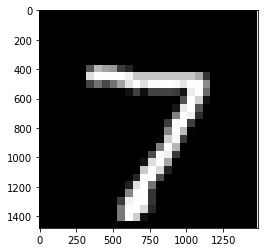

In [47]:
%pylab inline --no-import-all
from PIL import Image
img= Image.open(r'7.bmp')
plt.imshow(img,cmap='gray',vmin=0,vmax=255)

# Prediction

Before executing the belwo cell please fetch few data and update in below cell.

#### SESSION
Please find the authservice_session cookie content and update the SESSION in below cell.
#### KUBEFLOW_URL
Please find out the Kubeflow URL and update KUBEFLOW_URL in below cell.
#### SELDON_DEPLOYMENT_NAME
Seldon Deployment name you can find by executing the below command.
```
kubectl get seldondeployment -n kubeflow
```

In [48]:
import numpy as np
from PIL import Image
import requests, json

image_file = '7.bmp'
data = np.array(Image.open(image_file).convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)

SESSION="MTYxMzQ3MjM5OHxOd3dBTkVoYVVGcFpRMDlPVlVkTlQweFRUMEpWUmtkSVdVWTFORXBYUzBoTU5WTllVVVJHUmxkSFVVYzNNa3hFUkZoUlVFWlBOVUU9fKM3SPEjMMJ8Y7a6w1-iAZuGbGa0_Ed1HPBmmZzdZ6sj"

NAMESPACE="kubeflow"

KUBEFLOW_URL="http://mip-bd-vm182.mip.storage.hpecorp.net:10029"

SELDON_DEPLOYMENT_NAME="seldon-deployment-end-to-end-pipeline-f7pvs"

cookies = {
    'authservice_session': SESSION
}

headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Host': 'mip-bd-vm158.mip.storage.hpecorp.net'
}


np.set_printoptions(threshold=np.inf)
json_request= json.dumps({"data":{"ndarray":data.tolist()}})

URL = "{}/seldon/{}/{}/api/v0.1/predictions".format(KUBEFLOW_URL,NAMESPACE,SELDON_DEPLOYMENT_NAME)
response = requests.post(URL, headers=headers, cookies=cookies, data=json_request)
prediction = response.json()['data']['ndarray'][0][0]['classes']

print("The input image is: {}.".format(prediction))


The input image is: 7.
